In [1]:
from distributed import Executor, progress

In [2]:
e = Executor('dscheduler:8786')

In [3]:
e.restart()

<Executor: scheduler=dscheduler:8786 processes=3 cores=96>

In [4]:
n_cores = sum(e.ncores().values())
n_cores

96

In [5]:
from time import sleep
futures = e.map(sleep, [0.1] * (n_cores * 100), pure=False)
progress(futures)

In [6]:
import subprocess


def install_libs():
    libs = 'scikit-learn joblib pandas matplotlib'.split()
    return subprocess.check_call('conda install -yq'.split() + libs)

In [7]:
install_libs()

0

In [8]:
e.run(install_libs)

{'10.112.0.6:48953': 0, '10.112.1.3:47835': 0, '10.112.2.3:54556': 0}

In [9]:
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

In [10]:
def load_cv_split(split_idx):
    data = load_digits()  # XXX: hard-coded
    splitted = train_test_split(data.data, data.target,
                               test_size=0.20,
                               random_state=split_idx)
    return split_idx, splitted

# Pre-compute the cross-validation splits and broadcast them to each worker
cv_splits = e.scatter([load_cv_split(i) for i in range(3)], broadcast=True)

In [11]:
cv_splits

[<Future: status: finished, key: 81c5b12b631fd1a707c92bba905da1bd>,
 <Future: status: finished, key: c4a211ca3ae298909c78bde726f3109b>,
 <Future: status: finished, key: c9787180397815b66c284d1b25f44589>]

In [12]:
from joblib import hash, Memory
from time import time


def evaluate_one(model_class, cv_split, parameters):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    t0 = time()
    model = model_class(**parameters).fit(X_train, y_train)
    training_time = time() - t0

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)
    
    results = {
        'split_idx': split_idx,
        'training_time': training_time,
        'train_score': train_score,
        'validation_score': validation_score,
        'parameters_hash': hash(parameters),
        'parameters': parameters,
    }
    return results

In [13]:
import random

def launch_search(executor, model_class, param_space, n_combinations=100,
                  random_seed=None):
    rng = random.Random(random_seed)
    futures = []
    param_space = list(param_space)
    rng.shuffle(param_space)
    for params in param_space[:n_combinations]:
        for cv_split in cv_splits:
            f = executor.submit(evaluate_one, model_class,
                                cv_split, params)
            futures.append(f)
            
    return futures

In [14]:
from sklearn.grid_search import ParameterGrid
from sklearn.svm import SVC
import numpy as np


param_space = ParameterGrid({
    'C': np.logspace(-10, 10, 101),
    'gamma': np.logspace(-10, 10, 101),
    'tol': np.logspace(-4, -1, 4),
})

results = launch_search(e, SVC, param_space, n_combinations=n_cores * 10)

In [15]:
progress(results)

In [28]:
len([f for f in results if f.done()])

2880

In [29]:
ready_list = e.gather([f for f in results if f.done()])

In [30]:
ready = pd.DataFrame.from_dict(ready_list)
ready.head(5)

,parameters,parameters_hash,split_idx,train_score,training_time,validation_score
0,"{'C': 6309.5734448, 'tol': 0.0001, 'gamma': 3....",094738064f71d368b80094299ef61fcf,0,0.986082,0.097658,0.980556
1,"{'C': 6309.5734448, 'tol': 0.0001, 'gamma': 3....",094738064f71d368b80094299ef61fcf,1,0.984690,0.191810,0.986111
2,"{'C': 6309.5734448, 'tol': 0.0001, 'gamma': 3....",094738064f71d368b80094299ef61fcf,2,0.989562,0.127663,0.961111
3,"{'C': 2.51188643151e-05, 'tol': 0.1, 'gamma': ...",a852e269bd2538c412d615a5c98895d5,0,0.107168,0.713491,0.080556
4,"{'C': 2.51188643151e-05, 'tol': 0.1, 'gamma': ...",a852e269bd2538c412d615a5c98895d5,1,0.105776,0.711305,0.083333


In [31]:
ready.describe()

,split_idx,train_score,training_time,validation_score
count,2880.000000,2880.000000,2880.000000,2880.000000
mean,1.000000,0.571340,0.590848,0.255476
std,0.816638,0.443502,0.235034,0.350647
min,0.000000,0.105776,0.054801,0.077778
25%,0.000000,0.105776,0.585081,0.077778
50%,1.000000,0.971120,0.646429,0.080556
75%,2.000000,1.000000,0.714909,0.083333
max,2.000000,1.000000,1.380149,0.994444


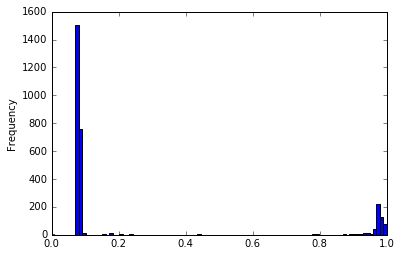

In [32]:
%matplotlib inline
ready['validation_score'].plot(kind='hist', bins=np.linspace(0, 1, 100));

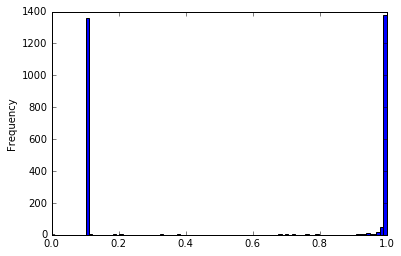

In [33]:
ready['train_score'].plot(kind='hist', bins=np.linspace(0, 1, 100));

In [34]:
mean_evaluations = ready.groupby('parameters_hash').agg({
    'train_score': np.mean,
    'validation_score': np.mean,
    'training_time': np.mean,
}).reset_index()

all_parameters = pd.DataFrame.from_dict(list(ready['parameters']))
all_parameters['parameters_hash'] = ready['parameters_hash']

evaluations = (
    mean_evaluations
    .merge(all_parameters)
    .drop(['parameters_hash'], axis=1)
)

In [35]:
top = evaluations.sort_values(by='validation_score', ascending=False).head(10)
top

,training_time,train_score,validation_score,C,gamma,tol
1466,0.361082,1.00000,0.987963,3.981072e+05,0.001585,0.0100
1760,0.295207,1.00000,0.987963,6.309573e+09,0.001585,0.0010
1600,0.343584,1.00000,0.987963,6.309573e+07,0.001585,0.0001
1601,0.343584,1.00000,0.987963,6.309573e+07,0.001585,0.0001
1758,0.295207,1.00000,0.987963,6.309573e+09,0.001585,0.0010
2667,0.272575,0.99884,0.987963,6.309573e-01,0.001585,0.0100
1599,0.343584,1.00000,0.987963,6.309573e+07,0.001585,0.0001
1759,0.295207,1.00000,0.987963,6.309573e+09,0.001585,0.0010
1465,0.361082,1.00000,0.987963,3.981072e+05,0.001585,0.0100
2668,0.272575,0.99884,0.987963,6.309573e-01,0.001585,0.0100


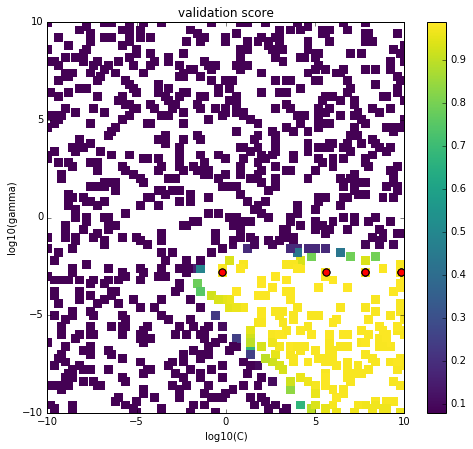

In [36]:
import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']),
                np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(8, 7))
plot_param_map(evaluations, evaluations['validation_score'], 'validation score')
plt.scatter(np.log10(top['C']), np.log10(top['gamma']), c='r', s=50);

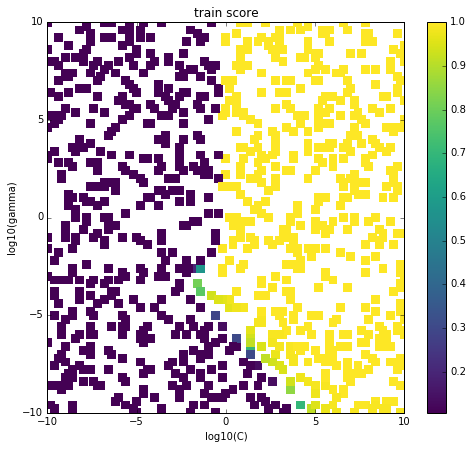

In [37]:
plt.figure(figsize=(8, 7))
plot_param_map(evaluations, evaluations['train_score'], 'train score')

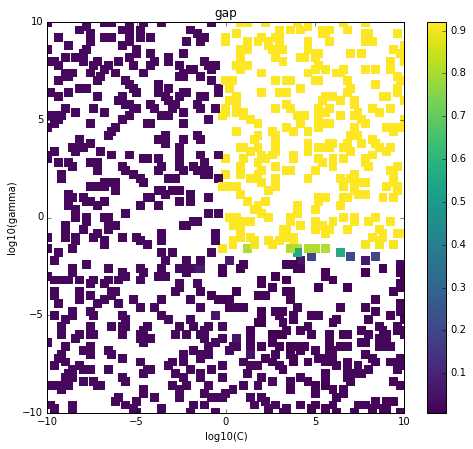

In [38]:
plt.figure(figsize=(8, 7))
gap = evaluations['train_score'] - evaluations['validation_score']
plot_param_map(evaluations, gap, 'gap')

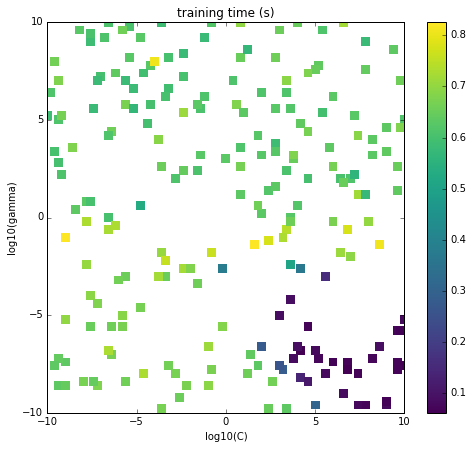

In [39]:
plt.figure(figsize=(8, 7))
high_tol = evaluations[evaluations['tol'] == 0.1]
plot_param_map(high_tol, high_tol['training_time'], 'training time (s)')